In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
import sys
import pathlib
import functools
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision.transforms import *
import time

In [2]:
sys.path.insert(0,'/home/Druzhinina/project')
from data import HCP_MRI

In [3]:
import grad_cam

random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
CHECKPOINTS_DIR = '/home/Druzhinina/project/checkpoints_skull/' #best_acc_model_NetGradRandomiz_all_subject_bs42


In [4]:
# print(X.shape, y.shape)

In [5]:
PATH_TO_MRI = '/home/datasets/HCP_T1_fsl/HCP_T1_pm'
data_dir = pathlib.Path('/home/datasets/adni')
behavioral_path = os.path.join(data_dir / 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

HCP absmax before normalization: 435.0126647949219
Dataset size: 1112
Labels distribution: (array([0, 1]), array([605, 507]))

Example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


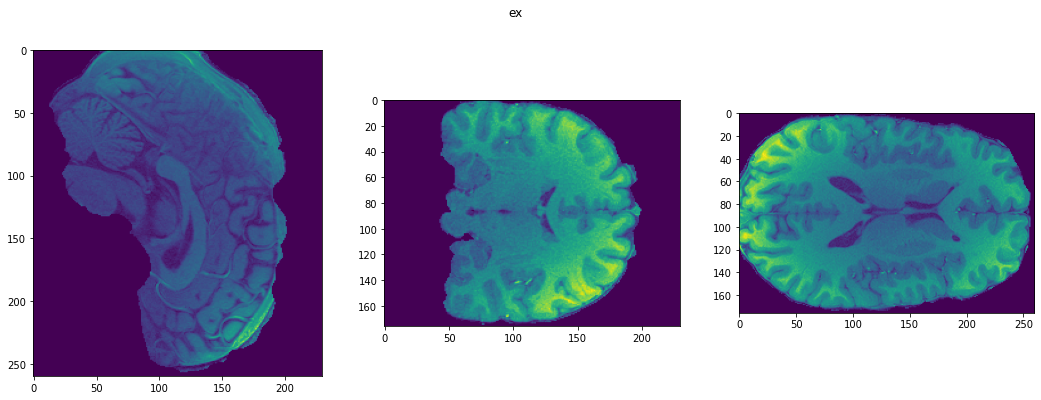

In [6]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
    
hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= behavioral_path,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
)
hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)

transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
hcp_dataset.transform = transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Dataset size: {}".format(len(hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(hcp_dataset.labels, return_counts=True)))

print("Example:")
img, target = hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [17]:
img[0, 100, 200,]

tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  388.,  406.,
         333.,  427.,  413.,  459.,  506.,  632.,  724.,  696.,  712.,  651.,
         595.,  597.,  695.,  739.,  772.,  704.,  718.,  718.,  783.,  703.,
         741.,  698.,  723.,  686.,  806.,  820.,  878.,  880.,  878.,  837.,
         851.,  860.,  855.,  908.,  931.,  942.,  923.,  933.,  885.,  730.,
         705.,  609.,  641.,  644.,  710.,  667.,  688.,  775., 

In [9]:
nii_path = '/home/datasets/HCP_T1/102614/unprocessed/3T/T1w_MPR1/102614_3T_T1w_MPR1.nii.gz'
im = nib.load(nii_path).get_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


In [18]:
im[ 100, 200,]

array([ 113,  110,  245,  220,  237,  201,  230,  204,  160,  179,  210,
        218,  238,  246,  210,  235,  201,  291,  232,  303,  275,  152,
        176,  203,  261,  222,  203,  273,  391,  324,  218,  179,  160,
        229,  303,  290,  343,  282,  290,  246,  287,  378,  334,  376,
        343,  371,  313,  382,  435,  372,  327,  287,  321,  281,  292,
        354,  340,  255,  357,  369,  347,  333,  285,  269,  245,  198,
        143,  131,  105,  184,  114,  223,  184,  172,   84,   78,  190,
        195,  164,   86,   96,  268,  151,   55,   76,  131,   48,   78,
        416,  244,   70,  188,  317,  274,  233,  256,  192,  264,  282,
        355,  280,  365,  312,  328,  342,  331,  363,  356,  293,  323,
        365,  369,  283,  318,  298,  445,  365,  270,  313,  327,  392,
        161,  332,  337,  290,  154,   96,  367,  439,  393,  394,  357,
        392,  480,  486,  406,  426,  399,  530,  613,  561,  523,  552,
        624,  610,  579,  585,  562,  490,  503,  5

In [11]:
im.shape

(256, 320, 320)

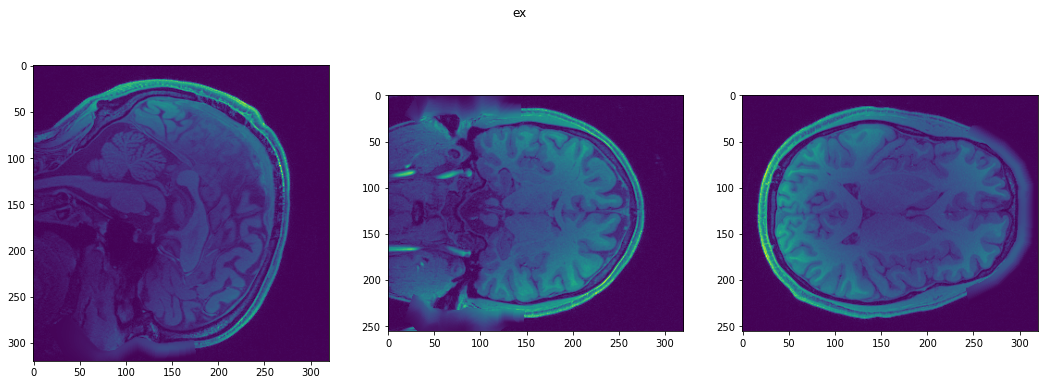

In [12]:
plot_central_cuts(im[np.newaxis,:,:,:], title="ex", t = None)

In [22]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(c, 2*c, kernel_size=3),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=3),
            nn.Flatten(),
#             nn.Linear(in_features=4*c*5*5*5, out_features=2),
            nn.Linear(in_features=35840, out_features=2)
        )
        self.gradients = None
        
  
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [23]:
if torch.cuda.is_available():
  device = torch.device("cuda:2")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [2,3,1,0]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

Let's use [2, 3, 1, 0] GPUs!


In [24]:
def get_prediction(net, data_loader, device):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

In [25]:
!nvidia-smi

Sat Jan  9 16:07:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   37C    P0    39W / 250W |  16230MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   35C    P0    37W / 250W |  13528MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [26]:
torch.cuda.empty_cache()

In [31]:
isTrain = True

In [28]:
hcp_dataset[0][0].shape[1:]

torch.Size([176, 260, 230])

## Grad CAM

In [32]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_NetGrad_skull_strip_bs42'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(len(hcp_dataset)//2)), batch_size=1, shuffle=False)
#     masks_grad = grad_cam.get_masks(model.module, loader, device, mask_type='grad_cam', size =hcp_dataset[0][0].shape[1:] )
#     np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam_part1'), masks_grad)
# else:
#     masks_grad1 = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam_part1.npy'))

In [14]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_NetGrad_skull_strip_bs42'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(len(hcp_dataset)//2,len(hcp_dataset))), batch_size=1, shuffle=False)
    masks_grad = grad_cam.get_masks(model.module, loader, device, mask_type='grad_cam', size =hcp_dataset[0][0].shape[1:] )
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam_part2'), masks_grad)
else:
    masks_grad2 = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam_part2.npy'))

In [35]:
#check 
model = model.to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, '30_epoch_model_NetGrad_skull_strip_bs42'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(2)), batch_size=1, shuffle=False)
grad_m = grad_cam.get_masks(model.module, loader, device, mask_type='grad_cam', size =hcp_dataset[0][0].shape[1:] )

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


In [39]:
roi_img = nib.Nifti1Image(masks_grad1.mean(axis=0),affine=np.eye(4))

In [47]:
mean = masks_grad1.mean(axis=0)

In [40]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()

In [55]:
grad_m[0][np.newaxis,:,:,:].shape

(1, 176, 260, 230)

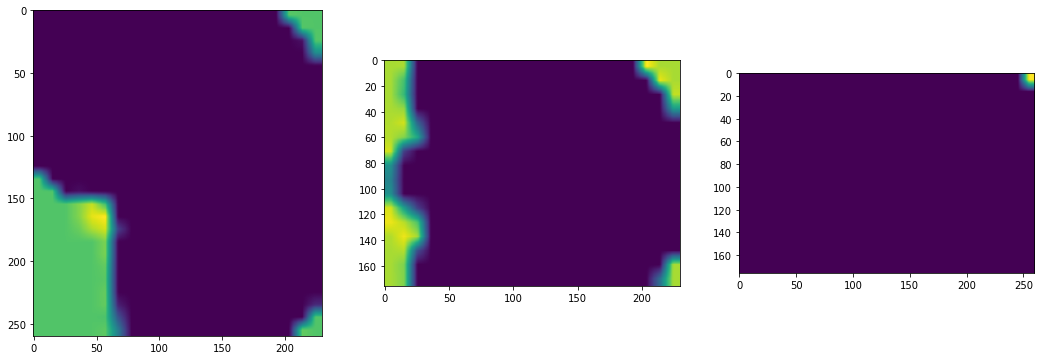

In [54]:
 plot_central_cuts(grad_m[0][np.newaxis,:,:,:], title="", t=None)

In [51]:
hcp_dataset[3][0].numpy()[np.newaxis,:,:,:].shape

(1, 1, 176, 260, 230)

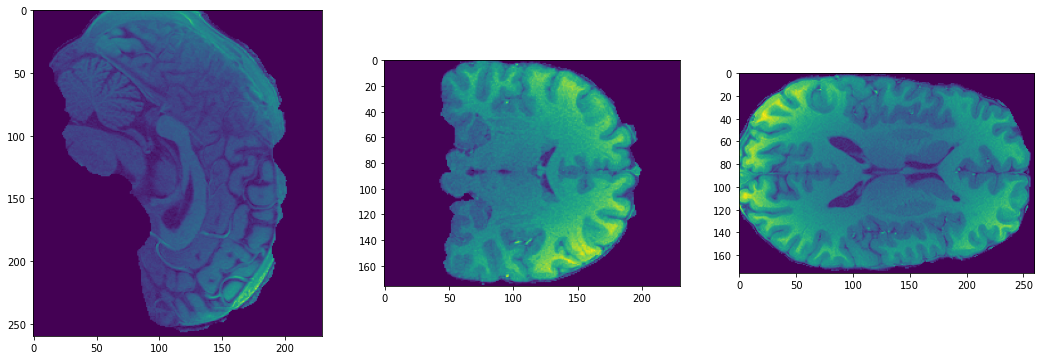

In [53]:
 plot_central_cuts(hcp_dataset[0][0].numpy(), title="", t=None)

In [18]:
print(masks_grad1.shape)

(556, 206, 250, 220)


In [21]:
1112* 206*250* 220 / 1024.0**3

11.73369586467743

In [22]:
hcp_dataset.labels[550]

1

In [15]:
labels = hcp_dataset.labels==0

In [16]:
len(labels[:len(hcp_dataset)//2])

556

In [16]:
mean1 = masks_grad1[labels[:len(hcp_dataset)//2]].mean(axis=0)
print(mean1.shape)
np.save(os.path.join(CHECKPOINTS_DIR,'grad_cam_part1_mean_labels_0'), mean1)
# mean2 = masks_grad2[labels[len(hcp_dataset)//2:]].mean(axis=0)

(176, 260, 230)


In [16]:
mean2 = masks_grad2[labels[len(hcp_dataset)//2:]].mean(axis=0)
print(mean2.shape)
np.save(os.path.join(CHECKPOINTS_DIR,'grad_cam_part2_mean_labels_0'), mean2)

(176, 260, 230)


In [25]:
mean1 =  np.load(os.path.join(CHECKPOINTS_DIR, 'grad_cam_part1_mean_labels_0.npy'))
mean2 =   np.load(os.path.join(CHECKPOINTS_DIR, 'grad_cam_part2_mean_labels_0.npy'))
mean = (mean1 + mean2)/2

In [26]:
mean.shape

(176, 260, 230)

In [22]:
mean1 = masks_grad1.mean(axis=0)
mean2 = masks_grad2.mean(axis=0)
mean_ax0 = (mean1 + mean2)/2

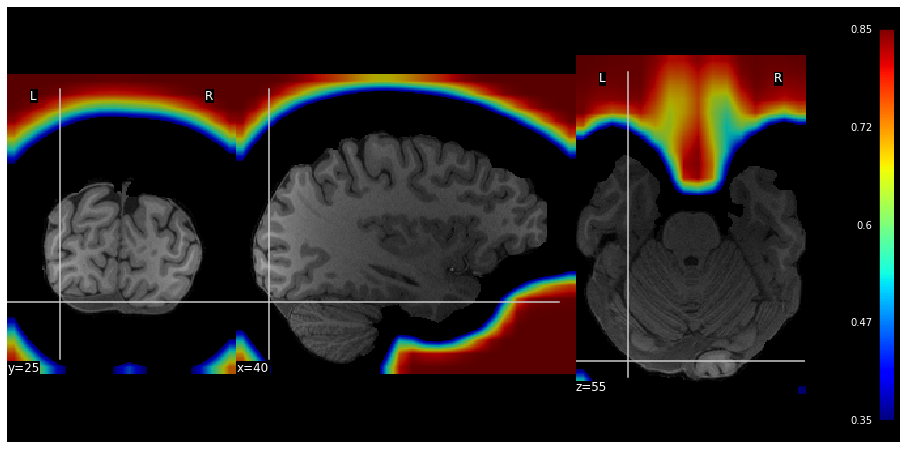

In [24]:
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(mean_ax0,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[3][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, cut_coords = (40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()
fig.savefig("grad_cam_skull_mean_(40, 25, 55)_tr0.35.png", bbox_inches='tight')

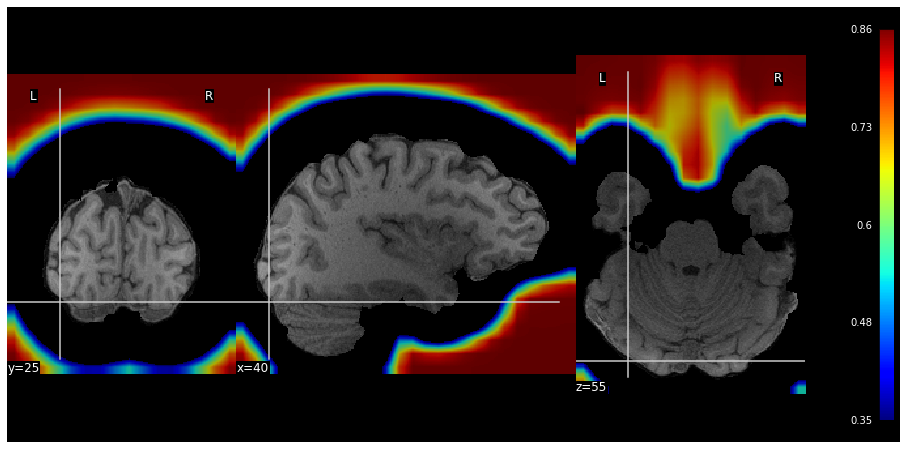

In [27]:
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(mean,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[2][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, cut_coords = (40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()
fig.savefig("grad_cam_skull_mean_labels_0_(40, 25, 55)_tr0.35.png", bbox_inches='tight')

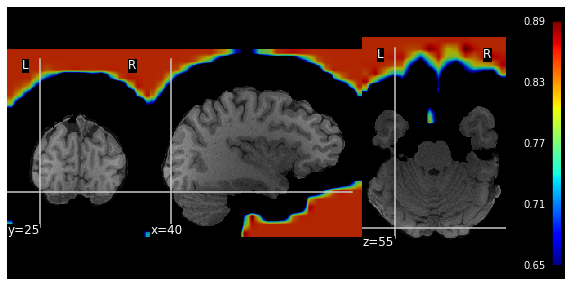

In [20]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad1[2],affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[2][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img ,cut_coords=(40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.65)
plt.show()
fig.savefig("grad_cam_rand_male_1_0.65.png", bbox_inches='tight')

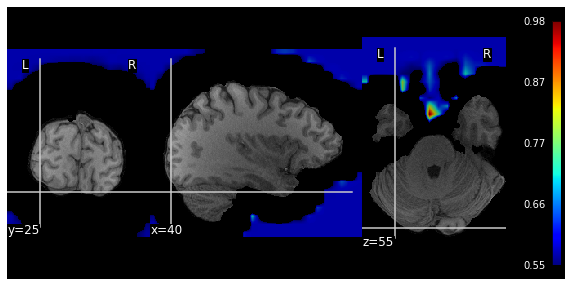

In [37]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(grad_m[1],affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[1][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img ,cut_coords=(40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()
fig.savefig("grad_cam_0.png", bbox_inches='tight')

In [15]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()

In [19]:
hcp_dataset[3][0].shape

torch.Size([1, 206, 250, 220])

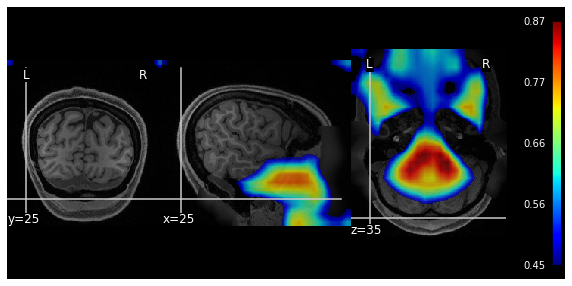

In [52]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(mean,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[3][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.45)
plt.show()
fig.savefig("gс.png", bbox_inches='tight')

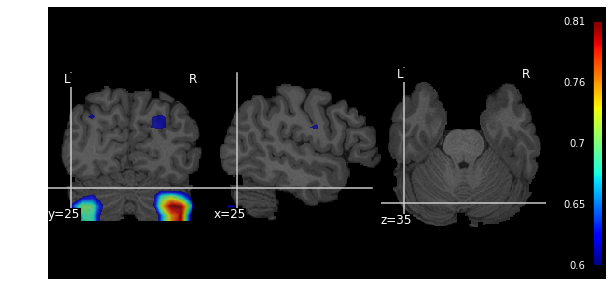

In [90]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.6)
plt.show()
fig.savefig("grad_cam.png", bbox_inches='tight')

## Guided Back-propagation

In [15]:
isTrain = False

In [30]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_NetGrad_skull_strip_bs42'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(len(hcp_dataset)//2)), batch_size=1, shuffle=False)
    masks_gb = grad_cam.get_masks(model.module, loader, device, mask_type='guided_backprop')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_gb_part1'), masks_gb)
else:
    masks_gb_1 =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gb_part1.npy'))
    

In [32]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_NetGrad_skull_strip_bs42'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(len(hcp_dataset)//2,len(hcp_dataset) )), batch_size=1, shuffle=False)
    masks_gb = grad_cam.get_masks(model.module, loader, device, mask_type='guided_backprop')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_gb_part2'), masks_gb)
else:
    masks_gb_2 =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gb_part2.npy'))

In [33]:
mean1 = masks_gb_1.mean(axis=0)
mean2 = masks_gb_2.mean(axis=0)
mean_ax0 = (mean1 + mean2)/2

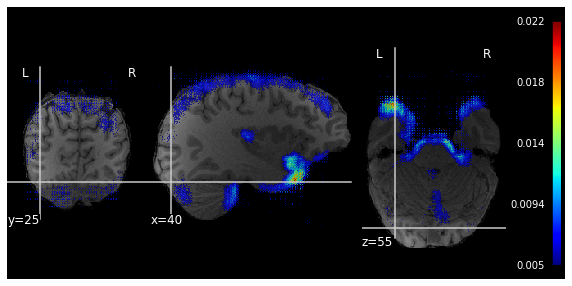

In [36]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(mean_ax0,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[0][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img ,cut_coords=(40,25,55), axes=axes,colorbar=True,cmap='jet',threshold=0.005)
plt.show()
fig.savefig("gb_skull_mean_0.005.png", bbox_inches='tight')

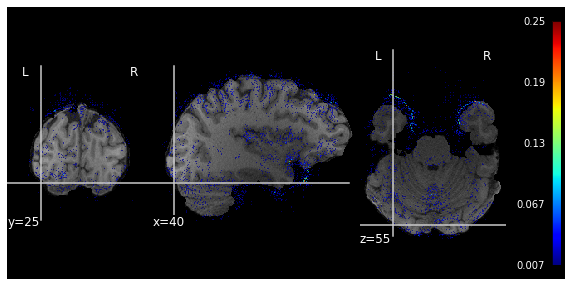

In [42]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb_1[3],affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[2][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img ,cut_coords=(40,25,55), axes=axes,colorbar=True,cmap='jet',threshold=0.007)
plt.show()
fig.savefig("gb_rand_male_1_0.007.png", bbox_inches='tight')

In [22]:
hcp_dataset.labels

array([1, 0, 1, ..., 0, 0, 1])

In [17]:
labels = hcp_dataset.labels==1

In [18]:
mean1 = masks_gb_1[labels[:len(hcp_dataset)//2]].mean(axis=0)
print(mean1.shape)
np.save(os.path.join(CHECKPOINTS_DIR,'gb_part1_mean_labels_1'), mean1)

(176, 260, 230)


In [29]:
mean2 = masks_gb_2[labels[len(hcp_dataset)//2:]].mean(axis=0)
print(mean2.shape)
np.save(os.path.join(CHECKPOINTS_DIR,'gb_part2_mean_labels_1'), mean2)

(176, 260, 230)


In [23]:
mean1 =  np.load(os.path.join(CHECKPOINTS_DIR, 'gb_part1_mean_labels_0.npy'))
mean2 =   np.load(os.path.join(CHECKPOINTS_DIR, 'gb_part2_mean_labels_0.npy'))
mean = (mean1 + mean2)/2

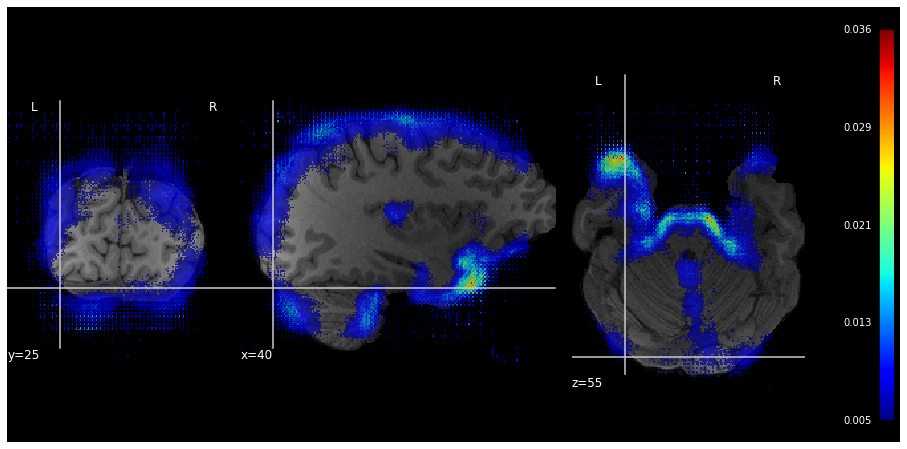

In [29]:
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(mean,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[3][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img, bim_img,cut_coords = (40,25,55), axes=axes,colorbar=True,cmap='jet',threshold=0.005)
plt.show()
fig.savefig("gb_skull_mean_labels_0_female_(40,25,55)_tr0.005.png", bbox_inches='tight')

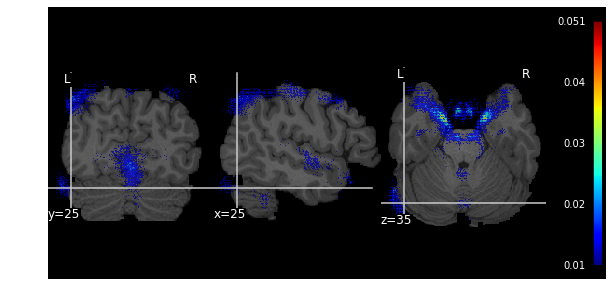

In [89]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb[y==1].mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.01)
plt.show()
fig.savefig("guided backpropagation.png", bbox_inches='tight')

## DICE

In [ ]:
def dice(x, y):
    overlap = x == y
    return 2 * overlap.sum() / (x.size + y.size)

In [ ]:
gm = masks_grad.mean(axis=0)
gbm = masks_gb.mean(axis=0)

In [4]:
g_b = dice(gm > 0.6, gbm > 0.01)
print('Dice between Grad Cam mask and Guided Back-propagation', g_b)

NameError: name 'gm' is not defined